In [410]:
import numpy as np

In [411]:
import networkx as nx

In [412]:
% matplotlib inline
import matplotlib.pyplot as plt

In [413]:
from scipy.optimize import minimize

# Read data from file

In [414]:
positions_file = "./MarkerPositioning/dataset_1_positions.txt"
relations_file = "./MarkerPositioning/dataset_1_relations.txt"

In [415]:
def read_positions(positions_file):
    x = []
    y = []

    with open(positions_file) as f1:
        for line in f1.readlines():
            p_x = int(line.split(":")[1].split(", ")[0])
            p_y = int(line.split(":")[1].split(", ")[1])
            x.append(p_x)
            y.append(p_y)

#     x = np.array(x) / (np.max(x) - np.min(x))
#     y = np.array(y) / (np.max(y) - np.min(y))

    x = np.array(x) / np.std(x)
    y = np.array(y) / np.std(y)
    
    return x, y

In [416]:
def read_relations(relations_file):
    edges = []

    with open(relations_file) as f1:
        i = 0
        for line in f1.readlines():
            start = int(line.split(":")[0]) - 1
            ends = line.split(":")[1].split(",")
            for end in ends:
                i += 1
                end = int(end) - 1
                edges.append((start, end))    
    return edges

In [417]:
def get_distance(i, j, x, y):
    return np.sqrt((x[i] - x[j]) ** 2 + (y[i] - y[j]) ** 2)

In [418]:
def get_distances_from_relations(x, y, edges):
    D = np.array([
        get_distance(i, j, x, y)
        for i, j in edges
    ])
    return D

In [419]:
x, y = read_positions(positions_file)

In [420]:
edges = read_relations(relations_file)

In [421]:
distances = get_distances_from_relations(x, y, edges)

# Solver class

In [422]:
class EuclideanSolver():
    distances = None
    graph = None
    edges = None
    
    def get_value(self, i, j, k):
        if k == i:
            return 1
        elif k == j:
            return -1
        else:
            return 0
        
    def get_pair(self, i, j):
        N = len(self.graph.nodes)
        return [self.get_value(i, j, k) for k in range(N)]
    
    def __init__(self, distances_dictionary):
        self.edges = distances_dictionary.keys()
        self.distances = np.array([distances_dictionary[edge] for edge in self.edges])
        
        self.graph = nx.Graph()
        self.graph.add_edges_from(self.edges)
        
    def initialize_distances(self):
        graph = self.graph.copy()
        for k, (i, j) in enumerate(graph.edges):
            graph.edges[i, j]['weight'] = np.sqrt(self.distances[k])
            
        matrix = np.array(nx.adjacency_matrix(graph).todense()) ** 2
        all_pairs = dict(nx.all_pairs_bellman_ford_path_length(graph))
        
        for n1 in graph.nodes:
            for n2 in graph.nodes:
                if (n1 == n2):
                    matrix[n1, n2] = 0
                if (n1 != n2) and (matrix[n1, n2] == 0):
                    matrix[n1, n2] = all_pairs[n1][n2] ** 2
                    
        return matrix
    
    def initialize_points(self, initial_matrix):
        N = len(self.graph.nodes)
        F = np.array(initial_matrix)
        e = np.ones((N, 1))
        J = np.eye(N) - (e @ e.T) / N
        T = -0.5 * (J @ F @ J)
        a, b = np.linalg.eig(T)
        top_indices = np.argsort(-a)[0:2]
        U = b[:, top_indices]
        L = np.diag(a[top_indices])
        P = U @ np.sqrt(L)
        return P
        
    def solve_optimization_problem(self, points):
        A = np.array([
            self.get_pair(i, j)
            for i, j in self.edges
        ]).astype(int)
                
        D = self.distances
        
        N = len(self.graph.nodes)
        
        prepared_points = np.hstack([
            points.T[0], 
            points.T[1]
        ])
        
        def f_to_minimize(P):
            x = P[:N]
            y = P[N:]

            p1 = (x[np.newaxis, :] @ A.T) ** 2

            p2 = (y[np.newaxis, :] @ A.T) ** 2
            
            return np.sum(np.abs((p1 + p2) - (D ** 2)))
        
        result = minimize(f_to_minimize, prepared_points)
        
        return np.vstack([
            result.x[:N],
            result.x[N:]
        ])
    
    def convert_to_dictionary(self, points):
        x, y = points[0], points[1]
        return {
            point: (x[index], y[index])
            for index, point in enumerate(self.graph.nodes)
        }
    
    def get_points(self):
        initial_distances_matrix = self.initialize_distances()
        initial_points = self.initialize_points(initial_distances_matrix)
        solved_points = self.solve_optimization_problem(initial_points)
        return self.convert_to_dictionary(solved_points)

# Usage

In [423]:
distances_dictionary = {
    edge: distances[index]
    for index, edge in enumerate(edges)
}

In [424]:
solver = EuclideanSolver(distances_dictionary)

In [425]:
solved_points = solver.get_points()

In [426]:
solved_points

{0: (1.6024376024374754, -0.8325389351007682),
 1: (0.6904511899232861, -1.1979918789738868),
 2: (-0.5449914462229948, -1.265019361530504),
 3: (1.089820281189906, 0.6170248493375069),
 4: (-0.07486204500661948, 0.2473668579497125),
 5: (0.12460458195150886, 1.2743103607893187),
 6: (-1.1632968969239603, 0.07106499179007357),
 7: (-1.7658574695294234, 1.0857792208509265)}

In [431]:
points = solved_points.keys()
x2 = np.array([solved_points[point][0] for point in points])
y2 = np.array([solved_points[point][1] for point in points])

In [448]:
def rotation_matrix(theta):
    theta = np.radians(theta)
    c, s = np.cos(theta), np.sin(theta)
    R = np.array(((c, -s), (s, c)))
    return R

In [520]:
R = rotation_matrix(-10)

In [521]:
points1 = np.vstack([x, y])

In [522]:
rotated_x = -(R @ points1)[0]
rotated_y = (R @ points1)[1]

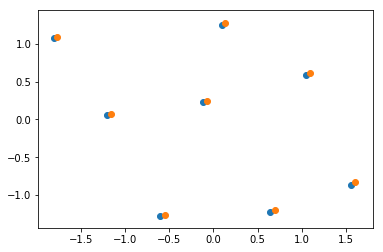

In [532]:
plt.scatter(rotated_x + 2.3, rotated_y - 1.8)
plt.scatter(x2, y2)